# Chest X-Ray Images (Pneumonia)
This dataset is taken from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
![Dataset samples](https://i.imgur.com/jZqpV51.png)

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children's Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients' routine clinical care.

In [ ]:
!pip install captum

In [ ]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix

from captum.attr import LayerGradCam, LayerAttribution
# To guarantee reproducible results
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2)

## GPU status check

In [ ]:
!nvidia-smi

Tue Oct  7 11:23:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Download and inspect pneumonia chest-xray dataset

In [ ]:
!wget -O chest_xray.zip https://www.piclab.ai/classes/cv2020/chest_xray.zip
!unzip -qo chest_xray.zip

--2025-10-07 12:03:55--  https://www.piclab.ai/classes/cv2020/chest_xray.zip
Resolving www.piclab.ai (www.piclab.ai)... 161.200.92.132
Connecting to www.piclab.ai (www.piclab.ai)|161.200.92.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1226148659 (1.1G) [application/zip]
Saving to: ‘chest_xray.zip’

chest_xray.zip      100%[===================>]   1.14G  11.2MB/s    in 1m 47s  

2025-10-07 12:05:43 (10.9 MB/s) - ‘chest_xray.zip’ saved [1226148659/1226148659]



In [ ]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [ ]:
### Dataset Augmentation (https://pytorch.org/docs/stable/torchvision/transforms.html) ###
transformTrain = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

transformTest =  transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### Dataloader for our dataset ###
pneumoniaTrainDataset = ImageFolder('chest_xray/train/', transform=transformTrain)
pneumoniaTestDataset = ImageFolder('chest_xray/test/', transform=transformTest)

print('Total train set images :', len(pneumoniaTrainDataset))
print('Total test set images :', len(pneumoniaTestDataset))

Total train set images : 5216
Total test set images : 624


## Dataset visualization

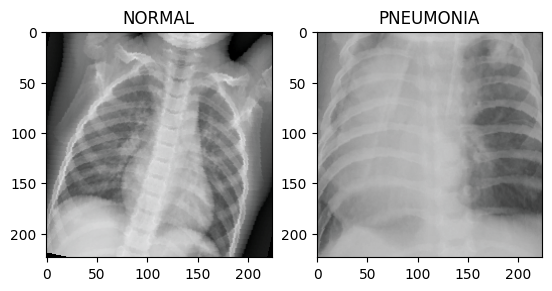

In [ ]:
normalImage, normalClassName = getImageFromDataset(pneumoniaTrainDataset, 0)
pneumoniaImage, pneumoniaClassName = getImageFromDataset(pneumoniaTrainDataset, 3000)


_, figure = plt.subplots(1,2)

figure[0].imshow(normalImage,cmap='gray')
figure[0].title.set_text(normalClassName)

figure[1].imshow(pneumoniaImage,cmap='gray')
figure[1].title.set_text(pneumoniaClassName)
plt.show()

## Define CNN network for pneumonia classification based on modified VGG-8

In [ ]:
### Build simple CNN ###
class pneumoniaNet(nn.Module):
  def __init__(self):
    super(pneumoniaNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc6 = nn.Linear(512*7*7, 4096)
    self.fc7 = nn.Linear(4096, 2)


  def forward(self, input): # 1 x 3 x 224 x 224
    x = self.pool1(F.relu(self.conv1(input)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = self.pool4(F.relu(self.conv4(x)))

    ###

    ###
    x = x.view(-1, 512*7*7) ### change to (1,25088)
    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x

In [ ]:
### Build simple CNN ###
class pneumoniaNet(nn.Module):
  def __init__(self):
    super(pneumoniaNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc6 = nn.Linear(512*7*7, 4096) ### (inputnode=25088, outputnode=4096)
    self.fc7 = nn.Linear(4096, 2)


  def forward(self, input): # 1 x 3 x 224 x 224
    x = self.pool1(F.relu(self.conv1(input)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = self.pool4(F.relu(self.conv4(x)))

    x_5_1 = self.pool5_1(F.relu(self.conv5_1(x)))
    x_5_2 = self.pool5_2(F.relu(self.conv5_2(x)))

    x = x_5_1 + x_5_2 ### output size of this line is (512,7,7)
    x = x.view(-1, 512*7*7) ### change to (1,25088)

    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x

## Construct the model, optimizer and loss function

In [ ]:
pneuNet = pneumoniaNet()

### Network Debugging

In [ ]:
output = pneuNet(torch.zeros((1,3,224,224)))

In [ ]:
import torch
from torch import nn, optim
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- compute class weights ---
labels = [label for _, label in pneumoniaTrainDataset.samples]
counts = Counter(labels)
num_samples = sum(counts.values())
class_weights = [num_samples / counts[i] for i in range(len(counts))]
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

# --- define model / loss / optimizer / scheduler ---
pneuNet = pneumoniaNet().to(device)

###Add loss function and Adam optimizer ##
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
#optimizer = optim.Adam(pneuNet.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
optimizer = optim.Adam(pneuNet.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

pneumoniaTrainDatasetLoader = DataLoader(pneumoniaTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
pneumoniaTestDatasetLoader = DataLoader(pneumoniaTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Train the model

In [ ]:
#@title
pneuNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pneuNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

pneumoniaTrainDatasetLoader = DataLoader(pneumoniaTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
pneumoniaTestDatasetLoader = DataLoader(pneumoniaTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader), ncols=100)
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData

      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )

      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):

  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:', ncols=100):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader), ncols=100)
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      loss.backward()
      optimizer.step()


      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)

    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [ ]:
### TODO : Train the model by using trainAndTestModel function ###
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(pneumoniaTrainDatasetLoader,pneumoniaTestDatasetLoader, pneuNet, optimizer, scheduler, criterion,
                                       trainEpoch=3)

Overall Training Progress::   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch 1 / 3


  0%|                                                                       | 0/326 [00:00<?, ?it/s]

  0%|                                                                        | 0/39 [00:00<?, ?it/s]

Epoch 2 / 3


  0%|                                                                       | 0/326 [00:00<?, ?it/s]

  0%|                                                                        | 0/39 [00:00<?, ?it/s]

Epoch 3 / 3


  0%|                                                                       | 0/326 [00:00<?, ?it/s]

  0%|                                                                        | 0/39 [00:00<?, ?it/s]

In [ ]:
print(bestAccuracy, bestPredicted, allLabels, bestNet)

88.3 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1

In [ ]:
#@title
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(pneumoniaTrainDatasetLoader, pneumoniaTestDatasetLoader,
                                                                    pneuNet,
                                                                    optimizer, scheduler, criterion,
                                                                    trainEpoch=3)

Overall Training Progress::   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch 1 / 3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|                                                                       | 0/326 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Visualize the training and testing accuracy

In [ ]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

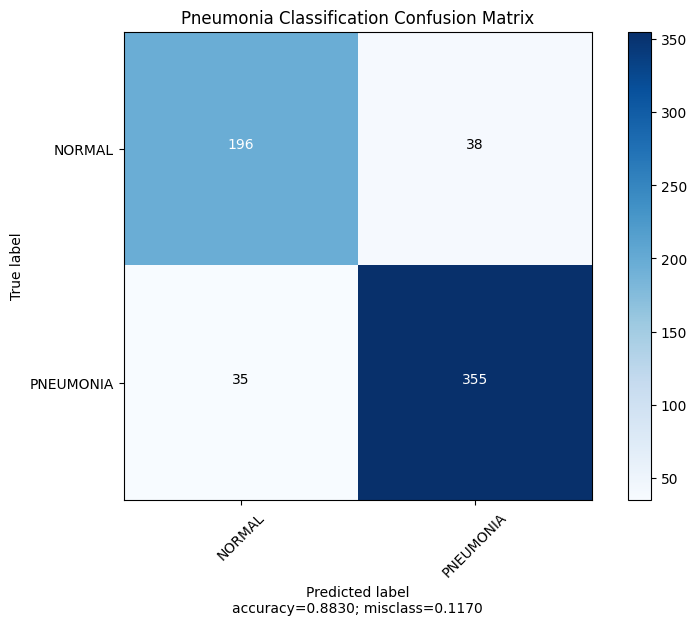

TP:196 TN:38 FP:35 FN:355


In [ ]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix,
                      normalize    = False,
                      target_names = pneumoniaTrainDataset.classes,
                      title        = "Pneumonia Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

## Confusion Matrix

In [ ]:
def showRandomSamples(labels, predicted, testDataset, sampleNum=5):
  equals = labels == predicted
  correctIdx = np.where(equals == 1)[0].tolist()
  incorrectIdx = np.where(equals == 0)[0].tolist()

  randomCorrectIdx = random.sample(correctIdx, sampleNum)
  randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

  _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

  ### Plot Correct ###
  for imageIdx in range(len(randomCorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomCorrectIdx[imageIdx])
    figure[0,imageIdx].imshow(image,cmap='gray')
    figure[0,imageIdx].title.set_text('[CORRECT] '+className)

  for imageIdx in range(len(randomIncorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomIncorrectIdx[imageIdx])
    figure[1,imageIdx].imshow(image,cmap='gray')
    predictedClassName = testDataset.classes[predicted[randomIncorrectIdx[imageIdx]]]
    figure[1,imageIdx].title.set_text('Actual:'+className+' Predicted:' + predictedClassName)

  plt.show()

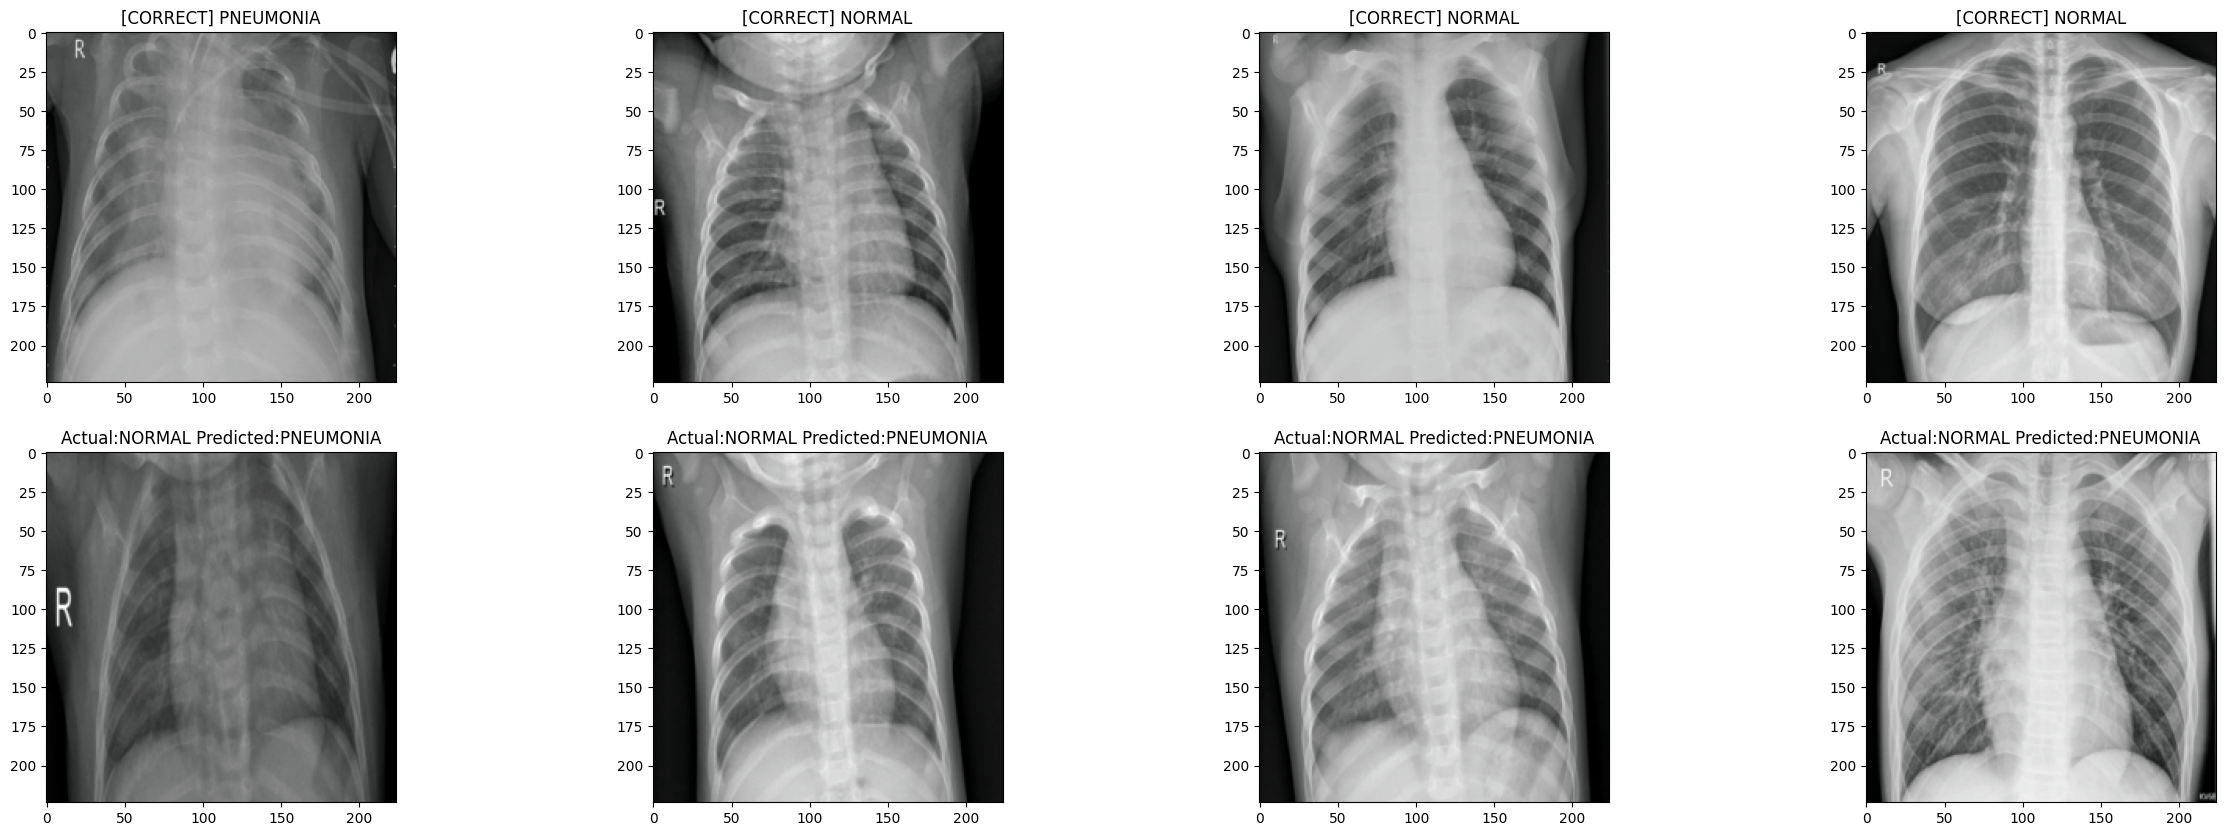

In [ ]:
showRandomSamples(allLabels,bestPredicted,pneumoniaTestDataset,sampleNum=4)

## Prediction on individual images

In [ ]:
def getLayer(model, layerName):
    for name in layerName.split("."):
        model = getattr(model, name)
    return model

def scale(x):
    x -= x.min()
    x /= x.max() + np.spacing(1)
    x *= 255
    return np.array(x, dtype=np.uint8)

def overlayHeatmap(img, grad):
    imgnp = np.array(img)
    grad = grad.squeeze().cpu().detach().numpy()
    gradImg = scale(grad)
    heatmap = cv2.applyColorMap(gradImg, cv2.COLORMAP_JET)
    heatmap = heatmap[:, :, ::-1] # convert to rgb
    return cv2.addWeighted(imgnp, 0.5, heatmap, 0.5, 0)

def attribute(preprocImageTensor, originalInputImage ,net ,layername):
    output = net(preprocImageTensor)
    classNo = torch.argmax(output)


    intermediateLayer = getLayer(net, layername)
    layerGC = LayerGradCam(net, intermediateLayer)

    attr = layerGC.attribute(preprocImageTensor, classNo)
    heatmap = overlayHeatmap(originalInputImage, LayerAttribution.interpolate(attr, originalInputImage.shape[0:2], 'bilinear'))
    return heatmap, classNo.item()

torch.Size([1, 3, 224, 224])


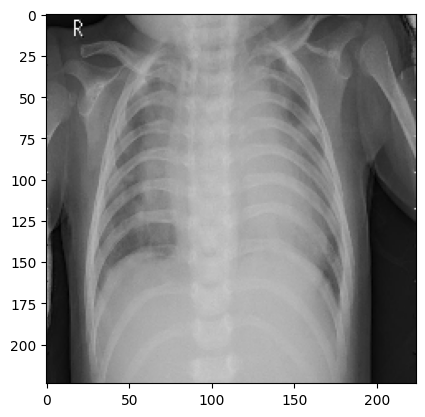

In [ ]:
sampleImage = cv2.imread('chest_xray/test/PNEUMONIA/person112_bacteria_538.jpeg')
sampleImage = cv2.resize(sampleImage, (224,224))
plt.imshow(sampleImage)

sampleTensor = ((sampleImage / 255) - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

sampleTensor = torch.from_numpy(sampleTensor).permute(2,0,1).unsqueeze(0).float().cuda()
sampleTensor.cuda()
print(sampleTensor.shape)

1


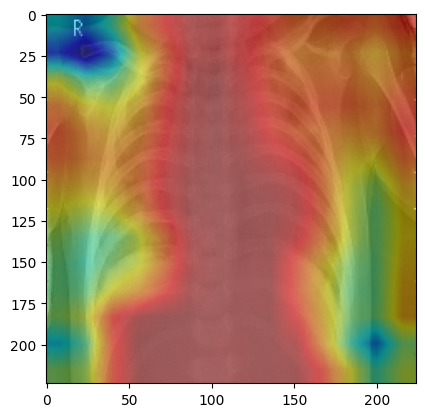

In [ ]:
heatMap, classNo = attribute(sampleTensor, sampleImage, bestNet, 'conv5_1') # We typically attach gradcam to last convolution layer
plt.imshow(heatMap)
print(classNo)